# **Predição de bugs**

### **Contexto**

Durante o processo de desenvolvimento de software podem acontecer diversas alterações no código e alguns bugs podem ser inseridos de forma não intencional. 

É muito importante que esses bugs sejam encontrados e corrigidos. Para isso, há diversas técnicas já conhecidas na comunidade de Engenharia de Software. Uma que vem sendo cada vez mais explorada é a utilização de algoritmos de ML para a realização dessa tarefa. 

### **Dataset**

Um dataset bem interessante que pode ser utilizada para predizer *bugs*, *features* e *perguntas* é o GitHub Bugs Prediction (https://www.kaggle.com/datasets/anmolkumar/github-bugs-prediction).

De forma resumida, o dataset contém o título e corpo de issues do github e para cada entrada há uma classe associada que diz qual se aquela issue está relacionada a uma feature, um bug ou uma dúvida. 

### **Tarefa**

Originalmente, o dataset foi projetado para dizer se uma issue do github é uma feature, bug ou pergunta. Entretanto, visto a necessidade de identificar bugs no software e com o objetivo de simplificar a tarefa pretende-se trabalhar com os seguintes objetivos: 


> **Induzir um classificador capaz de predizer se determinada issue do github é um bug ou não. Ou seja, uma tarefa binária.**

> **Comparar um rede neural profunda com o outros algoritmos**



In [119]:
# Importação das biliotecas necessárias importação do databaset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

**Descrição do dataset**

In [120]:
train_df = pd.read_json("embold_train_light.json").reset_index(drop=True)
train_extra_df = pd.read_json("embold_train_extra_light.json").reset_index(drop=True)

In [121]:
print("Linhas X Colunas")
print("*****************************************************************")
print("Embold_train - Dadaset de treino reduzido: ", train_df.shape)
print("Embold_train_extra - Dadaset de trein completo:", train_extra_df.shape)
print("*****************************************************************")

Linhas X Colunas
*****************************************************************
Embold_train - Dadaset de treino reduzido:  (1000, 3)
Embold_train_extra - Dadaset de trein completo: (1000, 3)
*****************************************************************


**Atributos do dataset**

1.   Título da issue: *title*
2.   Corpo da issue: *body*
2.   Classe da issue:: *body*


**Classes do dataset**

1.   Bug: *0*
2.   Feature: *1*
2.   Question:: *2*

**Classes do problema desse dataset**

1.   É Bug: *1*
2.   Não é bug: *0*





In [ ]:
train_df.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


## **Unificando os datasets.**

Tanto o Embold_train e Embold_train_extra contêm os dados rotulados que podem ser usados para treino, validação e teste. Para aumentar a quantidade de dados em todas as etapas, os dataset podem ser concatenados e as entradas duplicadas removidas. 

In [122]:
# Concatenando todos os dados
full_train_databset = pd.concat([train_df, train_extra_df]).drop_duplicates(keep='first')
train_extra_df = None
train_df = None

## **A quantidade de classes está balanceada?**

**IMPORTANTE! A quantidade de dados foi reduzida para a execução do trabalho.**


Essa é uma pergunta importante pois caso não esteja balanceada, será necessário criar classes sintéticas. 

Como pode ser notado no gráfico a seguir, a quantidade de respostas está totalmente desbalanceada com relação à quantidade de bugs e features. Entretanto, como a tarefa é classificar se é bugs ou não, não será necessário tratar a quantidade de classes. 

1    937
0    882
2    181
Name: label, dtype: int64


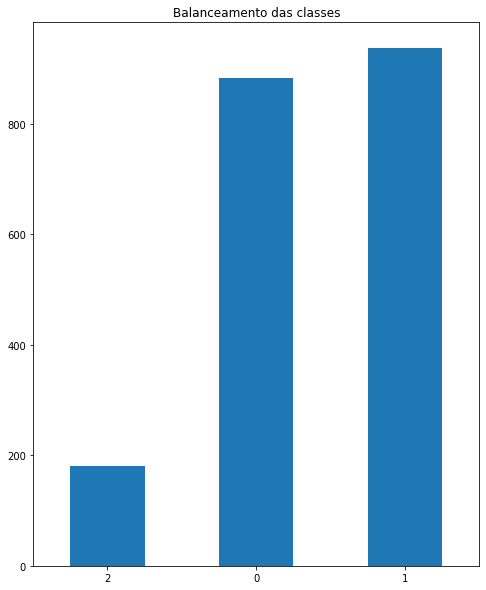

In [9]:
print(full_train_databset['label'].value_counts())

full_train_databset['label'].value_counts().sort_values().plot(kind = 'bar', figsize=(8,10), title="Balanceamento das classes", rot=0)

## **Transformando as classe Question em "Não é bug" IMPORTANTE!!!.**

Como mencionado, pretende-se trabalhar com apenas duas classes: "É bug" ou "Não é bug". ***É Bug*** será representado por 1 e ***Não é Bug*** representado por 0. 

**Perceba que bug é originalmente representado por 0. Sendo assim, pretende-se alterar essa classe 0 (do dataset original) para 1 e as classes 1 e 2 para 0.**


In [123]:
df_bug_oringal =  full_train_databset[full_train_databset["label"] == 0]
df_not_bug_oringal =  full_train_databset[full_train_databset["label"] != 0]

print("***********************************")
print("df_bug_oringal:", df_bug_oringal.shape)
print("df_bug_oringal classes:", np.unique(df_bug_oringal.label))
print("df_not_bug_oringal:", df_not_bug_oringal.shape)
print("df_not_bug_oringal classes:", np.unique(df_not_bug_oringal.label))
print("***********************************")


df_bug_oringal.loc[:, ('label')] = 1
df_not_bug_oringal.loc[:, ('label')] = 0

print("df_bug_oringal classes:", np.unique(df_bug_oringal.label))
print("df_not_bug_oringal classes:", np.unique(df_not_bug_oringal.label))

full_train_databset = pd.concat([df_bug_oringal, df_not_bug_oringal])
df_bug_oringal = None
df_not_bug_oringal = None
full_train_databset.head()


***********************************
df_bug_oringal: (882, 3)
df_bug_oringal classes: [0]
df_not_bug_oringal: (1118, 3)
df_not_bug_oringal classes: [1 2]
***********************************
df_bug_oringal classes: [1]
df_not_bug_oringal classes: [0]


,title,body,label
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,1
5,script stopped adding video's,a recent change in the youtube layout broke th...,1
9,en la org ull-esit-pl-1617 people info /nico/ ...,\r crguezl>ull-esit-pl-1617> people info /nico...,1
15,filter floating points,background\r \r we have identified a small num...,1


## **Balancemento das classes após a transformação do dataset?**

Esse será o dataset final, então é importante sabe como ele está.

0    1118
1     882
Name: label, dtype: int64


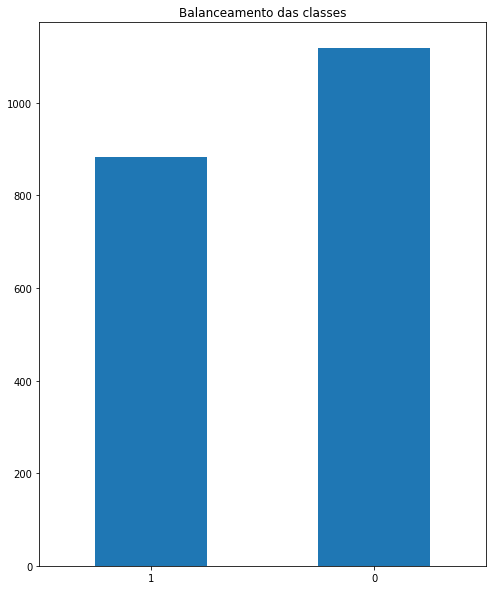

In [11]:
print(full_train_databset['label'].value_counts())

full_train_databset['label'].value_counts().sort_values().plot(kind = 'bar', figsize=(8,10), title="Balanceamento das classes", rot=0)

## **Concatenando Título e Body**

Como pode ser observado, tanto o título quanto o corpo contém informações que podem ser relevantes para a classificação. Portanto, pretende concatenar título e corpo em um único atributo. 

In [12]:
full_train_databset.head()

,title,body,label
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,1
5,script stopped adding video's,a recent change in the youtube layout broke th...,1
9,en la org ull-esit-pl-1617 people info /nico/ ...,\r crguezl>ull-esit-pl-1617> people info /nico...,1
15,filter floating points,background\r \r we have identified a small num...,1


In [124]:
def concat_title_body(x):
    return x['title'] + " " + x['body']   

full_train_databset['title_body']= full_train_databset.apply(lambda x : concat_title_body(x),axis=1)
full_train_databset.head()

,title,body,label,title_body
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,1,buggy behavior in selection ! screenshot from ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,1,enable pid on / pid off alarm actions for ardu...
5,script stopped adding video's,a recent change in the youtube layout broke th...,1,script stopped adding video's a recent change ...
9,en la org ull-esit-pl-1617 people info /nico/ ...,\r crguezl>ull-esit-pl-1617> people info /nico...,1,en la org ull-esit-pl-1617 people info /nico/ ...
15,filter floating points,background\r \r we have identified a small num...,1,filter floating points background\r \r we have...


### **Limpando texto**

Como pode ser notado, o texto está cheio de stopwords, links, caracteres especiais, etc.. 

Antes de realizar o treinamento, o atributo title_body será transformado para remover todo esse texto que oferece pouco ou nenhuma informação para a tarefa deste trabalho. 

In [14]:
print("Antes de limpar o texto")
full_train_databset.head()

Antes de limpar o texto


,title,body,label,title_body
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,1,buggy behavior in selection ! screenshot from ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,1,enable pid on / pid off alarm actions for ardu...
5,script stopped adding video's,a recent change in the youtube layout broke th...,1,script stopped adding video's a recent change ...
9,en la org ull-esit-pl-1617 people info /nico/ ...,\r crguezl>ull-esit-pl-1617> people info /nico...,1,en la org ull-esit-pl-1617 people info /nico/ ...
15,filter floating points,background\r \r we have identified a small num...,1,filter floating points background\r \r we have...


In [125]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.tokenize import TweetTokenizer
from bs4 import BeautifulSoup
import re

stop_words = stopwords.words('english')

stopword_list = stopwords.words('english') + ['u','the','us','say','that','he','me','she','get','rt','it','mt','via','not','and','let','so','say','dont','use','you', '','.', '``', '...', '\'s', '--', '-', 'n\'t', '_', '–','&']
tokenizer = TweetTokenizer()

def remove_extra_text(text):
  # Removendo html
  soup = BeautifulSoup(text, "html.parser")
  text = soup.get_text()
  
  # Removendo links, new lines, etc
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
  text = re.sub('@[^\s]+','',text)
  text =  re.sub('(\w+\.){2,}','',text)
  text = re.sub('[\s]+', ' ', text)
  text = re.sub('\.(?!$)', '', text)  
  text = re.sub(r'#([^\s]+)', r'\1', text) 
  text = re.sub('\b\w{,2}\b', '', text) 
  text = re.sub(' +', ' ', text)

  # stopwords
  tokens = tokenizer.tokenize(text)  
  text = ' '.join([tok for tok in tokens if len(tok) > 2 if tok not in stopword_list and not tok.isdigit()])

  return text

full_train_databset['title_body'] = full_train_databset['title_body'].apply(lambda x: remove_extra_text(x))
full_train_databset.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,body,label,title_body
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,1,buggy behavior selection screenshot 2016-02-
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,1,enable pid pid alarm actions arduino tc4 expec...
5,script stopped adding video's,a recent change in the youtube layout broke th...,1,script stopped adding video's recent change yo...
9,en la org ull-esit-pl-1617 people info /nico/ ...,\r crguezl>ull-esit-pl-1617> people info /nico...,1,org ull-esit-pl people info nico produce crash...
15,filter floating points,background\r \r we have identified a small num...,1,filter floating points background identified s...


## **Induzindo classificador baseline**

Como tarefa final, pretende-se induzir um classificador que seja bom o suficiente para classificar issues em bug ou não. Para verificar se os classificadores são bons o suficiente, inicialmente busca-se induzir um classificador que servirá como base de comparação para outros. Isso, todo classificador induzido deve ser melhor que esse baseline. 

Para esse trabalho, pretende-se utilizar o Random Forest como classificador base. 

### **Transformando Texto em Número**

Uam forma simples de transformar os dados textuais em numéricos é medindo a importância de cada palavra. Com isso, é possível criar um classificador base com algoritmos simples, como Random Forest, Regressão Linear, etc..

Para este trabalho, será usado o TF-IDF do sklearn (TfidfVectorizer).

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vetorizando 
vectorizer = TfidfVectorizer()
df_vectorized = vectorizer.fit_transform(full_train_databset['title_body'].values).toarray()

### **Validação do classificador baseline**

O classificador base será avaliado usando Stratified K-Folds cross-validator com K=5.

In [145]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [172]:
def evaluate_clf(clf, X, y, deep_learning=False ):

  skf = StratifiedKFold(n_splits=10)
  
  fold_index = 1
  score = []

  for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
      
    print("Training fold {} ...".format(fold_index))
    if deep_learning:
       
      clf.fit(X_train, y_train, epochs=150, verbose=False, validation_data = (X_test, y_test), batch_size=10)  
      
      print("Predicting fold {} ...".format(fold_index))

      _, accuracy = clf.evaluate(X_test, y_test)
      
      score.append(accuracy)
      print("_, accuracy", accuracy)      
    
    else:
      clf.fit(X_train, y_train)

      print("Predicting fold {} ...".format(fold_index))
      predicted = clf.predict(X_test)
    
      accuracy = accuracy_score(y_test, predicted)      
      score.append(accuracy)

      m = metrics.classification_report(y_test, predicted,target_names=['Bug', 'Não Bug'])
      print(m)

    fold_index = fold_index + 1

  return np.sum(score) / 10, 

In [166]:
acc = { }

### **Random Forest**

O Random Forest será o modelo baseline utilizado aqui. Os parâmetros e hiperparâmetros serão os utilizados por padrão pela lib sklearn.

In [167]:
clf = RandomForestClassifier(random_state=42)
rf_acc = evaluate_clf(clf, df_vectorized, full_train_databset['label'].values, False)

acc["RandomForest"] = rf_acc


Training fold 1 ...
Predicting fold 1 ...
              precision    recall  f1-score   support

         Bug       0.71      0.90      0.79       111
     Não Bug       0.81      0.54      0.65        89

    accuracy                           0.74       200
   macro avg       0.76      0.72      0.72       200
weighted avg       0.76      0.74      0.73       200

Training fold 2 ...
Predicting fold 2 ...
              precision    recall  f1-score   support

         Bug       0.69      0.85      0.76       111
     Não Bug       0.73      0.52      0.61        89

    accuracy                           0.70       200
   macro avg       0.71      0.68      0.68       200
weighted avg       0.71      0.70      0.69       200

Training fold 3 ...
Predicting fold 3 ...
              precision    recall  f1-score   support

         Bug       0.74      0.89      0.81       112
     Não Bug       0.82      0.60      0.69        88

    accuracy                           0.77       200
  

### **Neural Network**

Vamos utilizar Multi-layer Perceptron (MLP) do sklearn. 

In [168]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, verbose=True)
mlp_acc = evaluate_clf(clf, df_vectorized, full_train_databset['label'].values, False)

acc["Neural Network"] = mlp_acc

Training fold 1 ...
Predicting fold 1 ...
              precision    recall  f1-score   support

         Bug       0.77      0.79      0.78       111
     Não Bug       0.73      0.71      0.72        89

    accuracy                           0.76       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.76      0.75       200

Training fold 2 ...
Predicting fold 2 ...
              precision    recall  f1-score   support

         Bug       0.72      0.78      0.75       111
     Não Bug       0.70      0.63      0.66        89

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.71      0.71      0.71       200

Training fold 3 ...
Predicting fold 3 ...
              precision    recall  f1-score   support

         Bug       0.77      0.85      0.81       112
     Não Bug       0.78      0.68      0.73        88

    accuracy                           0.78       200
  

### **Modelo de Deep Learning**

Modelo de deep learn com 3 camadas. 


1.   12 neurônios e com função de ativação Relu
2.   8 neurônios e com função de ativação Relu
3.   1 neurônio e com função de ativação Relusigmoid




In [169]:
from keras.models import Sequential
from keras.layers import Dense

In [170]:
clf = Sequential()
clf.add(Dense(12, activation='relu'))
clf.add(Dense(8, activation='relu'))
clf.add(Dense(1, activation='sigmoid'))
clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

dl_acc = evaluate_clf(clf, df_vectorized, full_train_databset['label'].values, True)
acc["Deep Learn"] = dl_acc

Training fold 1 ...
Predicting fold 1 ...
7/7 [==============================] - 0s 4ms/step - loss: 0.8201 - accuracy: 0.7550
_, accuracy 0.7549999952316284
Training fold 2 ...
Predicting fold 2 ...
7/7 [==============================] - 0s 4ms/step - loss: 8.4640e-04 - accuracy: 1.0000
_, accuracy 1.0
Training fold 3 ...
Predicting fold 3 ...
7/7 [==============================] - 0s 4ms/step - loss: 2.9937e-05 - accuracy: 1.0000
_, accuracy 1.0
Training fold 4 ...
Predicting fold 4 ...
7/7 [==============================] - 0s 4ms/step - loss: 2.8547e-06 - accuracy: 1.0000
_, accuracy 1.0
Training fold 5 ...
Predicting fold 5 ...
7/7 [==============================] - 0s 4ms/step - loss: 4.1305e-07 - accuracy: 1.0000
_, accuracy 1.0
Training fold 6 ...
Predicting fold 6 ...
7/7 [==============================] - 0s 6ms/step - loss: 5.1636e-08 - accuracy: 1.0000
_, accuracy 1.0
Training fold 7 ...
Predicting fold 7 ...
7/7 [==============================] - 0s 4ms/step - loss: 9.1442

### **Qual o melhor classificador?**

Como pode ser notado, o modelo de deep lean conseguiu o resultado com relação a acurácia. 

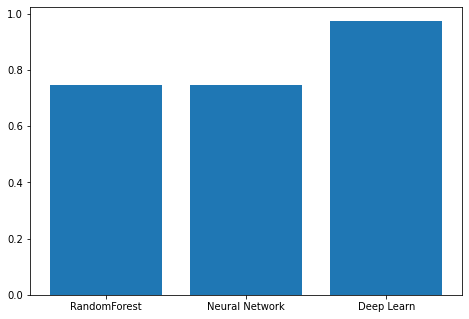

In [171]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
algo = ['RandomForest', 'Neural Network', 'Deep Learn']
acc = [acc["RandomForest"], acc["Neural Network"], acc["Deep Learn"]]
ax.bar(algo,acc)
plt.show()